In [1]:
# !pip install 'qiskit[visualization]' qiskit-ibm-runtime pylatexenc matplotlib

from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit
import pylatexenc
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [2]:
from google.colab import userdata
token = userdata.get('quantum_api_key')

QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum",
  overwrite=True,
)

In [3]:
# Load saved credentials
service = QiskitRuntimeService()

In [4]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Create empty circuit
example_circuit = QuantumCircuit(2)
example_circuit.measure_all()

# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

sampler = Sampler(backend)
job = sampler.run([example_circuit])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: cz3txtq1xvhg008e39qg
PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-03-05 01:54:54', stop='2025-03-05 01:54:56', size=4096>)])}, 'version': 2})


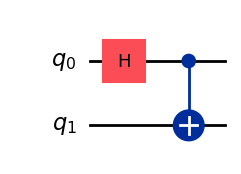

In [5]:
qc = QuantumCircuit(2)

qc.h(0)

qc.cx(0, 1)

qc.draw("mpl")

In [6]:
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

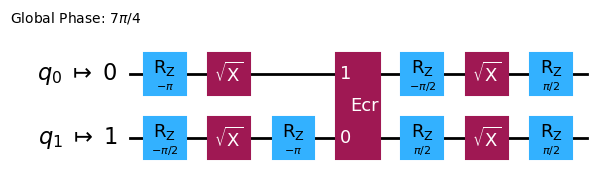

In [7]:
backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

In [8]:
# Construct the Estimator instance.

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cz3tz5mp6030008cak7g


In [9]:
job_result = job.result()

pub_result = job.result()[0]

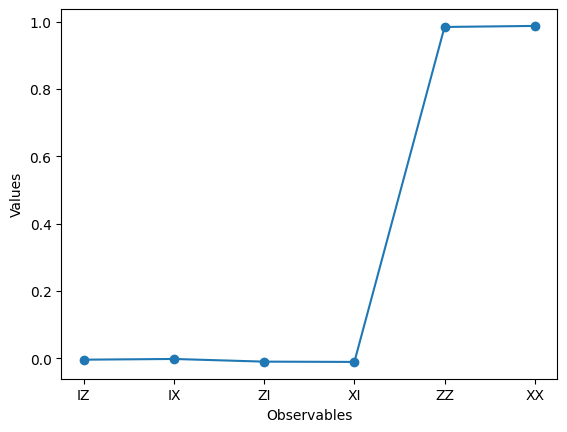

In [10]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()